In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib notebook

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

from scipy.optimize import minimize
import scipy.stats
import sklearn.mixture as sm

import myutils
from pyia import GaiaData

In [2]:
plt.style.use('notebook')

In [3]:
R = np.load('../data/jhelum_rotmat_init.npy')

In [4]:
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_transpose

class Jhelum(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the track of the PS1-A stream

    For more information about this class, see the Astropy documentation
    on coordinate frames in :mod:`~astropy.coordinates`.

    Parameters
    ----------
    representation : :class:`~astropy.coordinates.BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)

    phi1 : angle_like, optional, must be keyword
        The longitude-like angle corresponding to Orphan's orbit.
    phi2 : angle_like, optional, must be keyword
        The latitude-like angle corresponding to Orphan's orbit.
    distance : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    pm_phi1_cosphi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the longitude-like direction corresponding to
        the Orphan stream's orbit.
    pm_phi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the latitude-like direction perpendicular to the
        Orphan stream's orbit.
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    """
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential: [
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
        frame_specific_representation_info[coord.SphericalCosLatDifferential]
    frame_specific_representation_info[coord.UnitSphericalDifferential] = \
        frame_specific_representation_info[coord.SphericalDifferential]


@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.ICRS, Jhelum)
def icrs_to_jhelum():
    """ Compute the transformation from Galactic spherical to
        heliocentric Jhelum coordinates.
    """
    return R

@frame_transform_graph.transform(coord.StaticMatrixTransform, Jhelum, coord.ICRS)
def jhelum_to_icrs():
    """ Compute the transformation from heliocentric Jhelum coordinates to
        spherical Galactic.
    """
    return matrix_transpose(icrs_to_jhelum())

In [5]:
t = Table(fits.getdata('../data/jhelum_des.fits'))

In [6]:
g = GaiaData(t)
c = coord.SkyCoord(ra=g.ra, dec=g.dec,
                   pm_ra_cosdec=g.pmra, pm_dec=g.pmdec)

In [7]:
iso = Table.read('../data/mist_12.0_-1.50.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<5)
iso = iso[phasecut]

In [12]:
# distance modulus
d0 = 12.8*u.kpc
dm = 5*np.log10((d0.to(u.pc)).value)-5

# main sequence + rgb
i_gi = iso['DECam_g']-iso['DECam_i'] + 0.05
i_g = iso['DECam_g']+dm

i_left = i_gi - 0.4*(i_g/28)**5
i_right = i_gi + 0.55*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<21.3) & (poly[:,1]>19)
poly_main = poly[ind]

In [9]:
wangle = 180*u.deg

In [10]:
def jhelum_dist(phi1, d0=12.8, d1=0, d2=0):
    p1, p2 = 0, 20
    if (d1==0) | (d2==0):
        d1, d2 = d0, d0
    m = (d2-d1) / (p1-p2)
    return (m*phi1.wrap_at(wangle).value + d1) * u.kpc

In [13]:
cj = c.transform_to(Jhelum)
cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=jhelum_dist(cj.phi1, d0=d0.to(u.kpc).value),
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = cj_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
cj = coord.Galactic(rep).transform_to(Jhelum)

In [14]:
phi2_mask = (cj.phi2<1*u.deg) & (cj.phi2>0*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)
phi2off_mask = (cj.phi2<-3*u.deg) & (cj.phi2>-4*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)

points = np.array([g.g0 - g.i0, g.g0]).T
path_main = mpl.path.Path(poly_main)
cmd_mask = path_main.contains_points(points)

pm1_min = -8*u.mas/u.yr
pm1_max = -4*u.mas/u.yr
pm2_min = -2*u.mas/u.yr
pm2_max = 2.*u.mas/u.yr
pm_mask = ((cj.pm_phi1_cosphi2 < pm1_max) & (cj.pm_phi1_cosphi2 > pm1_min) & 
           (cj.pm_phi2 < pm2_max) & (cj.pm_phi2 > pm2_min))

bhb_gi_min = -0.7
bhb_gi_max = -0.2
bhb_g_min = 15.5
bhb_g_max = 16.5
bhb_mask = (g.g0-g.i0<bhb_gi_max) & (g.g0-g.i0>bhb_gi_min) & (g.g0<bhb_g_max) & (g.g0>bhb_g_min)

poly_bs = np.array([[0.2,18.9], [0.2, 19.9], [-0.25, 18.7], [-0.25,17.7]])
path_bs = mpl.path.Path(poly_bs)
bs_mask = path_bs.contains_points(points)

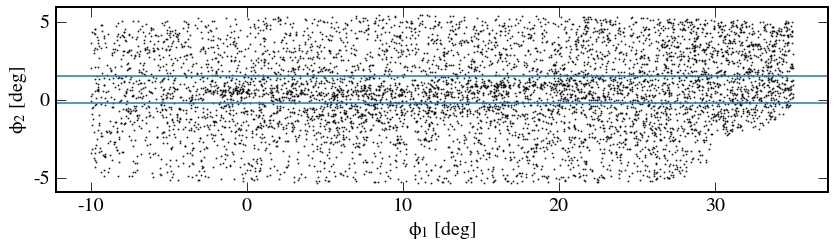

In [20]:
plt.figure(figsize=(12,10))
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask], 'k.', ms=2, alpha=0.7)
plt.gca().set_aspect('equal')

plt.axhline(1.5)
plt.axhline(-0.2)
# plt.axhline(-2)

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()

### Define narrow and wide tracks

In [21]:
def mad_std(x):
    """Median absolute deviation"""
    return 1.5 * np.median(np.abs(np.median(x)-x))

In [42]:
# setup bins for finding track
bin_size = 3 # deg
bins = np.arange(-5, 25+bin_size, bin_size)
bincen = 0.5 * (bins[1:] + bins[:-1])

In [43]:
# median track
stream_mask = pm_mask & cmd_mask
phi2_wide_mask = stream_mask & (cj.phi2 < 1.5*u.deg) & (cj.phi2 > -0.1*u.deg)

phi2_median, be, bn = scipy.stats.binned_statistic((cj.phi1[phi2_wide_mask]).wrap_at(wangle).degree, 
                                       cj.phi2[phi2_wide_mask].degree, 
                                       statistic='median', bins=bins)
phi2_sum, be = np.histogram((cj.phi1[phi2_wide_mask]).wrap_at(wangle).degree, 
                            bins=bins)
phi2_median_err = np.abs(phi2_median) / np.sqrt(phi2_sum)

deg = 2
ptrack = np.polyfit(bincen, phi2_median, deg, w=1 / np.sqrt(phi2_sum))

polytrack = np.poly1d(ptrack)
phi1_ = np.linspace(-5, 25, 100)
phi2_ = polytrack(phi1_)

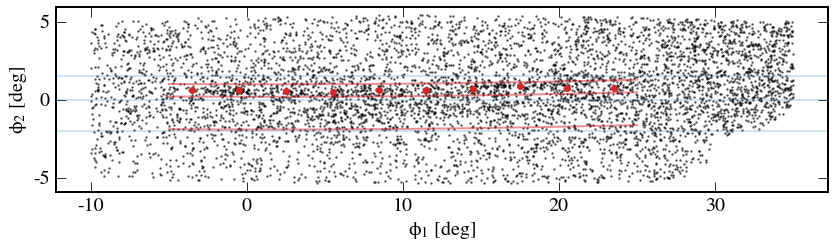

In [52]:
plt.figure(figsize=(12,10))
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask], 'k.', ms=3, alpha=0.5)
plt.plot(bincen, phi2_median, 'o', color='tab:red')

plt.plot(phi1_, phi2_+0.4, '-', color='tab:red', lw=2, alpha=0.5)
plt.plot(phi1_, phi2_-0.4, '-', color='tab:red', lw=2, alpha=0.5)
plt.plot(phi1_, phi2_-2.5, '-', color='tab:red', lw=2, alpha=0.5)

plt.axhline(1.5, color='tab:blue', lw=2, alpha=0.2)
plt.axhline(0, color='tab:blue', lw=2, alpha=0.2)
plt.axhline(-2, color='tab:blue', lw=2, alpha=0.2)

plt.gca().set_aspect('equal')
plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()

In [106]:
phi1_mask = (cj.phi1.wrap_at(wangle)>-5*u.deg) & (cj.phi1.wrap_at(wangle)<25*u.deg)
narrow_mask = phi1_mask & (np.abs(cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg)<=0.4*u.deg)
wide_mask = (phi1_mask & (cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg<-0.4*u.deg)
             & (cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg>-2.*u.deg))

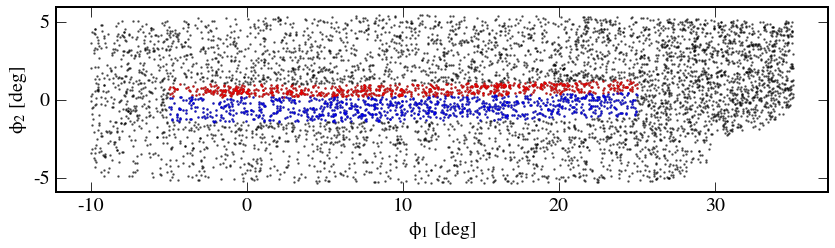

In [96]:
plt.figure(figsize=(12,10))
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask], 'k.', ms=3, alpha=0.5)
plt.plot(cj.phi1[pm_mask & cmd_mask & narrow_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask & narrow_mask], 
         'r.', ms=3, alpha=0.5)
plt.plot(cj.phi1[pm_mask & cmd_mask & wide_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask & wide_mask], 
         'b.', ms=3, alpha=0.5)

plt.gca().set_aspect('equal')
plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()

### Compare populations in narrow vs wide track

In [198]:
wide_masks = []

for pmax in np.arange(-0.4,-1.2,-0.05):
    wide_masks += [(phi1_mask & (cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg<pmax*u.deg)
                    & (cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg>=(pmax-0.8)*u.deg))]

Nwide = len(wide_masks)

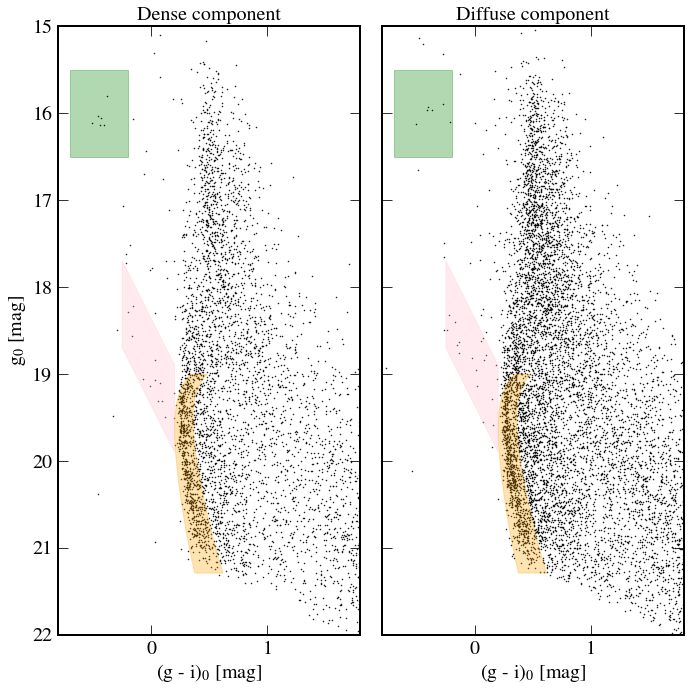

In [221]:
fig, ax = plt.subplots(1,2,figsize=(10,10), sharey=True, sharex=True)
plt.sca(ax[0])
plt.plot(g.g0[narrow_mask & pm_mask] - g.i0[narrow_mask & pm_mask], g.g0[narrow_mask & pm_mask], 
         'ko', ms=0.5, alpha=1, rasterized=True, label='')

# plt.plot(i_gi, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

pbs = mpl.patches.Polygon(poly_bs, color='pink', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pbs)

rect_xy = [bhb_gi_min, bhb_g_min]
rect_w = bhb_gi_max - bhb_gi_min
rect_h = bhb_g_max - bhb_g_min
pr_bhb = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='green', alpha=0.3)
plt.gca().add_artist(pr_bhb)

plt.xlim(-0.8,1.8)
plt.ylim(22, 15)
plt.xlabel('(g - i)$_0$ [mag]')
plt.ylabel('g$_0$ [mag]')
plt.title('Dense component', fontsize='medium')

plt.sca(ax[1])
plt.plot(g.g0[wide_mask & pm_mask] - g.i0[wide_mask & pm_mask], g.g0[wide_mask & pm_mask], 
         'ko', ms=0.5, alpha=1, rasterized=True, label='')

# plt.plot(i_gi, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

pbs = mpl.patches.Polygon(poly_bs, color='pink', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pbs)

pr_bhb = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='green', alpha=0.3)
plt.gca().add_artist(pr_bhb)

plt.xlim(-0.8,1.8)
plt.ylim(22, 15)
plt.xlabel('(g - i)$_0$ [mag]')
plt.title('Diffuse component', fontsize='medium')

plt.tight_layout()

In [203]:
bright_mask = g.g0<19.5*u.mag

In [204]:
wide_bhb2ms = np.empty(Nwide)
wide_bs2ms = np.empty(Nwide)
wide_bhb2bs = np.empty(Nwide)

for e in range(Nwide):
    wide_bhb2ms[e] = (np.nansum(wide_masks[e] & pm_mask & bhb_mask)/np.nansum(wide_masks[e] & pm_mask & cmd_mask
                                                                              & bright_mask))
    wide_bs2ms[e] = (np.nansum(wide_masks[e] & pm_mask & bs_mask)/np.nansum(wide_masks[e] & pm_mask & cmd_mask
                                                                            & bright_mask))
    wide_bhb2bs[e] = (np.nansum(wide_masks[e] & pm_mask & bhb_mask)/np.nansum(wide_masks[e] & pm_mask & bs_mask))

In [205]:
# narrow component
narrow_bhb2ms = (np.nansum(narrow_mask & pm_mask & bhb_mask)/np.nansum(narrow_mask & pm_mask & cmd_mask 
                                                                       & bright_mask))
narrow_bs2ms = (np.nansum(narrow_mask & pm_mask & bs_mask)/np.nansum(narrow_mask & pm_mask & cmd_mask 
                                                                     & bright_mask))
narrow_bhb2bs = (np.nansum(narrow_mask & pm_mask & bhb_mask)/np.nansum(narrow_mask & pm_mask & bs_mask))

# whole wide component
wideall_bhb2ms = (np.nansum(wide_mask & pm_mask & bhb_mask)/np.nansum(wide_mask & pm_mask & cmd_mask 
                                                                      & bright_mask))
wideall_bs2ms = (np.nansum(wide_mask & pm_mask & bs_mask)/np.nansum(wide_mask & pm_mask & cmd_mask 
                                                                    & bright_mask))
wideall_bhb2bs = (np.nansum(wide_mask & pm_mask & bhb_mask)/np.nansum(wide_mask & pm_mask & bs_mask))

# whole stream
stream_bhb2ms = (np.nansum((wide_mask | narrow_mask) & pm_mask & bhb_mask)/
                 np.nansum((wide_mask | narrow_mask) & pm_mask & cmd_mask & bright_mask))
stream_bs2ms = (np.nansum((wide_mask | narrow_mask) & pm_mask & bs_mask)/
                np.nansum((wide_mask | narrow_mask) & pm_mask & cmd_mask & bright_mask))
stream_bhb2bs = (np.nansum((wide_mask | narrow_mask) & pm_mask & bhb_mask)/
                 np.nansum((wide_mask | narrow_mask) & pm_mask & bs_mask))

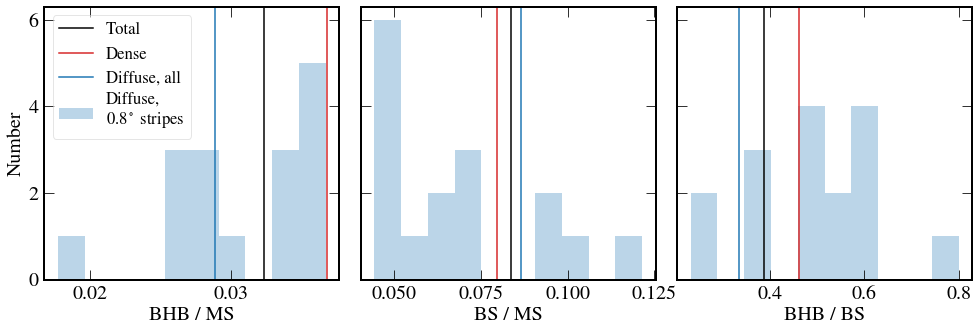

In [206]:
fig, ax = plt.subplots(1,3,figsize=(14,5), sharey=True)

plt.sca(ax[0])
plt.hist(wide_bhb2ms, alpha=0.3, label='Diffuse,\n0.8$^\circ$ stripes')
plt.axvline(stream_bhb2ms, color='k', label='Total')
plt.axvline(narrow_bhb2ms, color='tab:red', label='Dense')
plt.axvline(wideall_bhb2ms, label='Diffuse, all')

# plt.xlim(0,0.05)
plt.legend(fontsize='small', framealpha=0.5)
plt.ylabel('Number')
plt.xlabel('BHB / MS')

plt.sca(ax[1])
plt.hist(wide_bs2ms, alpha=0.3)
plt.axvline(narrow_bs2ms, color='tab:red')
plt.axvline(wideall_bs2ms)
plt.axvline(stream_bs2ms, color='k')

# plt.xlim(0,0.2)
plt.xlabel('BS / MS')

plt.sca(ax[2])
plt.hist(wide_bhb2bs, alpha=0.3)
plt.axvline(narrow_bhb2bs, color='tab:red')
plt.axvline(wideall_bhb2bs)
plt.axvline(stream_bhb2bs, color='k')

# plt.xlim(0,0.2)
plt.xlabel('BHB / BS')

plt.tight_layout()

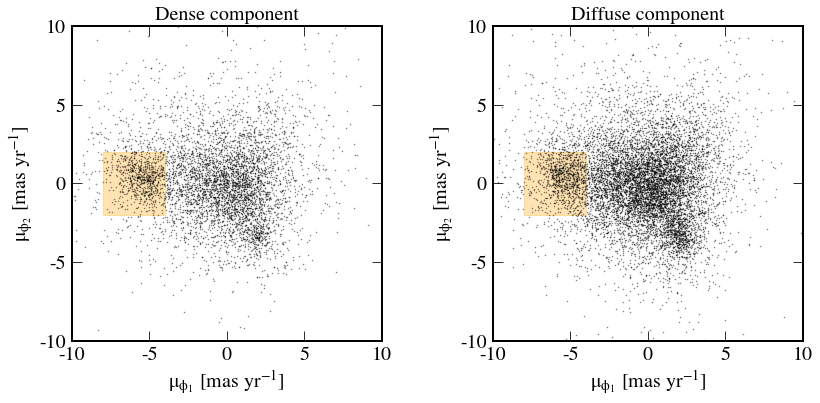

In [222]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
plt.sca(ax[0])
plt.plot(cj.pm_phi1_cosphi2[narrow_mask & cmd_mask].to(u.mas/u.yr), 
         cj.pm_phi2[narrow_mask & cmd_mask].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.5, rasterized=True)

rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Dense component', fontsize='medium')

plt.sca(ax[1])
plt.plot(cj.pm_phi1_cosphi2[wide_mask & cmd_mask].to(u.mas/u.yr), 
         cj.pm_phi2[wide_mask & cmd_mask].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.5, rasterized=True)

pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Diffuse component', fontsize='medium')

plt.tight_layout()